In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

# Load the Titanic dataset
file_folder = ('train.csv')
titanic_df = pd.read_csv(file_folder)

In [8]:
# Create a FamilySize column to identify groups

titanic_df['FamilySize'] = \
titanic_df['SibSp'] + titanic_df['Parch'] + 1


In [ ]:
#Let's peek at the first few rows to see our new, magical columns in action
titanic_df.drop(columns=['Ticket', 'Cabin','Embarked']).head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,FamilySize
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,2
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,2
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,1
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,8.4583,1
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,51.8625,1
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,21.0750,5
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,11.1333,3
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,30.0708,2


In [ ]:
# Filter for passengers who are part of a family (size > 1)

family_df = titanic_df[titanic_df['FamilySize'] > 1].copy()

In [12]:
# Sort the DataFrame by family size for a more organized network later
family_df.sort_values(by='FamilySize', ascending=False, inplace=True)

In [13]:
print("--- Passengers in a Family Group ---")
print(f"Total passengers with family: {len(family_df)}")
print(family_df[['Name', 'FamilySize', 'Survived']].head())

--- Passengers in a Family Group ---
Total passengers with family: 354
                                  Name  FamilySize  Survived
792            Sage, Miss. Stella Anna          11         0
201                Sage, Mr. Frederick          11         0
846           Sage, Mr. Douglas Bullen          11         0
863  Sage, Miss. Dorothy Edith "Dolly"          11         0
159         Sage, Master. Thomas Henry          11         0


In [ ]:
# Create an empty graph


G = nx.Graph()


In [ ]:
# Add a node for each passenger in a family
for index, row in family_df.iterrows():
    G.add_node(row['PassengerId'],
               name=row['Name'],
               survived=row['Survived'],
               family_size=row['FamilySize'])

In [ ]:
# Now, add edges to connect family members.
# We'll group by Ticket number to connect people traveling together.
for ticket, group in family_df.groupby('Ticket'):
    if len(group) > 1:
        # Create a list of passenger IDs in the group
        passenger_ids = group['PassengerId'].tolist()
                
        # Add edges connecting every member of the group
        for i in range(len(passenger_ids)):
            for j in range(i + 1, len(passenger_ids)):
                G.add_edge(passenger_ids[i], passenger_ids[j])

In [20]:
print("\n--- Network Stats ---")
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")


--- Network Stats ---
Number of nodes: 354
Number of edges: 257


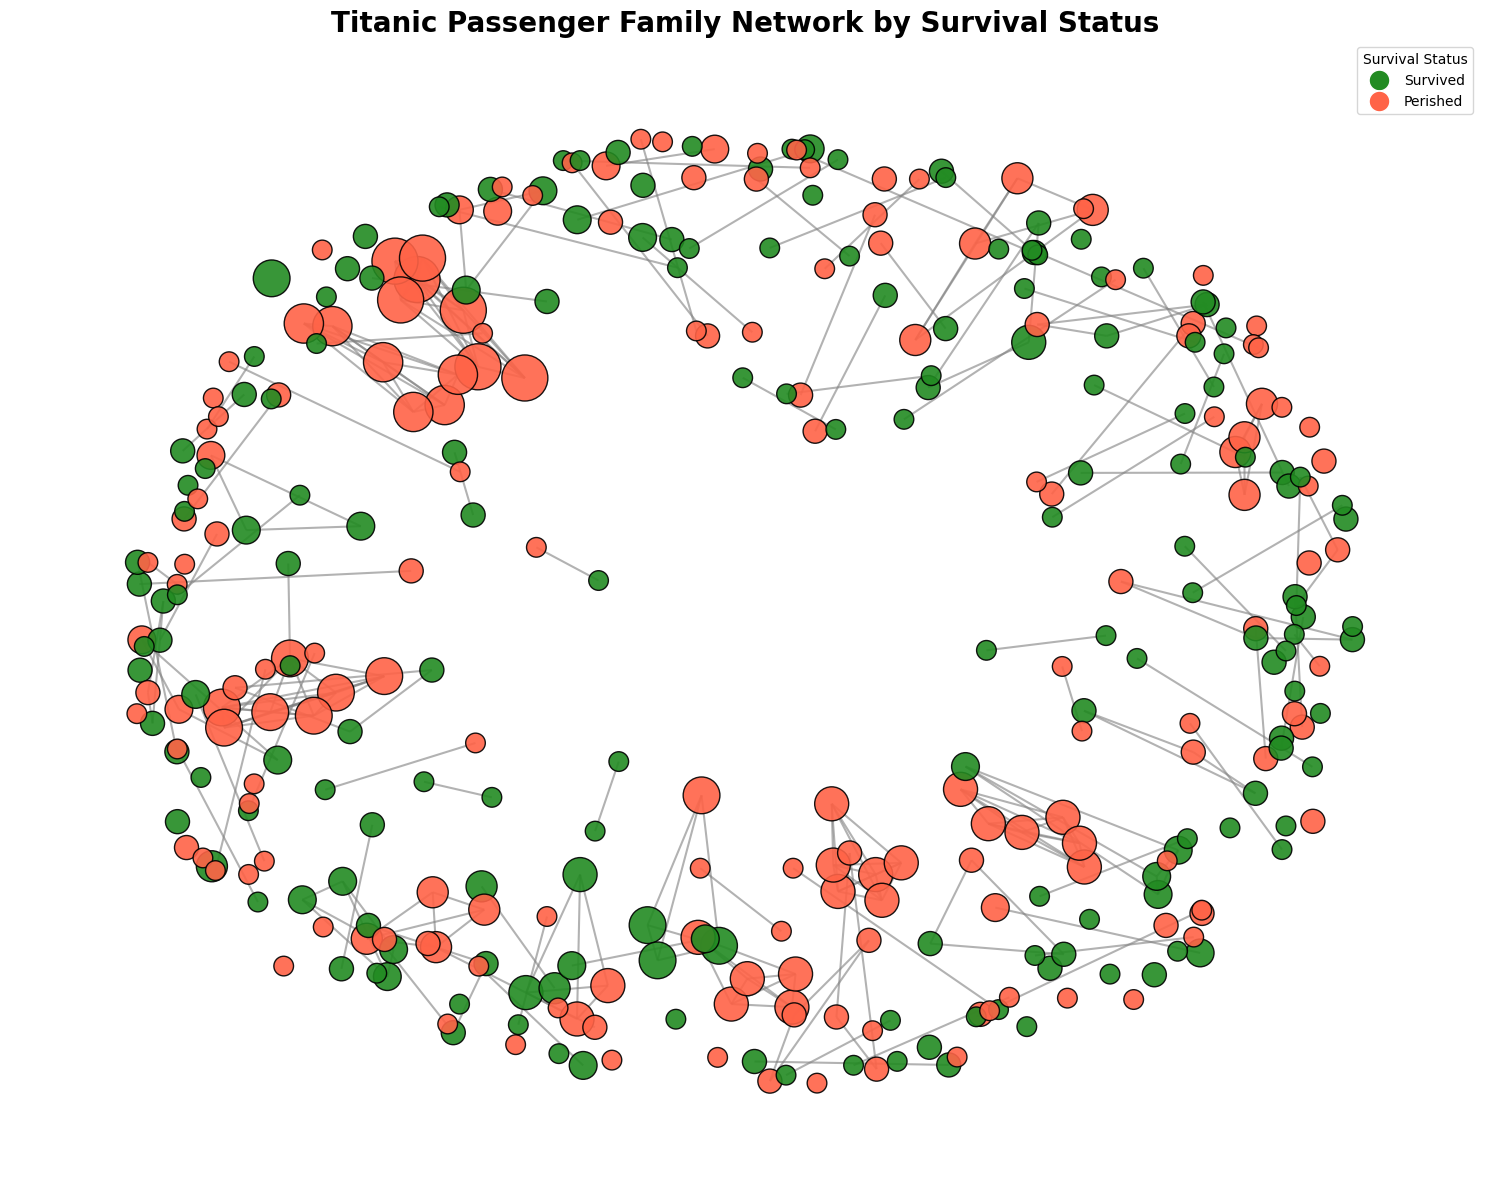

In [ ]:
#Create a figure to hold our plot7
plt.figure(figsize=(15, 12))

# Use a spring layout for the nodes. This spreads them out nicely.
pos = nx.spring_layout(G, k=0.3, iterations=50)

# Get node colors based on survival status
node_colors = [
    'forestgreen' if G.nodes[node]['survived'] == 1 else 'tomato'
    for node in G.nodes()
]

# Get node sizes based on family size
node_sizes = [
    G.nodes[node]['family_size'] * 100 for node in G.nodes()
]

# Draw the nodes, edges, and labels

nx.draw_networkx_nodes(G, pos, node_color=node_colors, 
                       node_size=node_sizes, alpha=0.9, 
                       edgecolors='black', linewidths=1)
nx.draw_networkx_edges(G, pos, edge_color='gray', width=1.5, alpha=0.6)

# Add a title and turn off the axis for a cleaner look
plt.title("Titanic Passenger Family Network by Survival Status",
           fontsize=20, fontweight='bold')
plt.axis('off')

# Create a custom legend

legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', label='Survived',
               markerfacecolor='forestgreen', markersize=15),
    plt.Line2D([0], [0], marker='o', color='w', label='Perished',
               markerfacecolor='tomato', markersize=15)
]
plt.legend(handles=legend_elements, title='Survival Status', loc='upper right')

plt.tight_layout()
plt.show()